In [1]:
import pyedflib
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import find_peaks
from matplotlib.backends.backend_pdf import PdfPages
import re
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
pip uninstall numpy
pip install --no-cache-dir numpy

SyntaxError: invalid syntax (2581674739.py, line 1)

rrun
Timestamp: 345.7636718, Event Label: 3, Stimulated Channel: LPIn1
start index 708123 end index 728603
rrunning
rrunning
rrunning
rrunning
rrunning
rrunning
rrunning
pks pos  []
flipped
The time to the first peak is 66.36 ms.
Value of peak 4.773


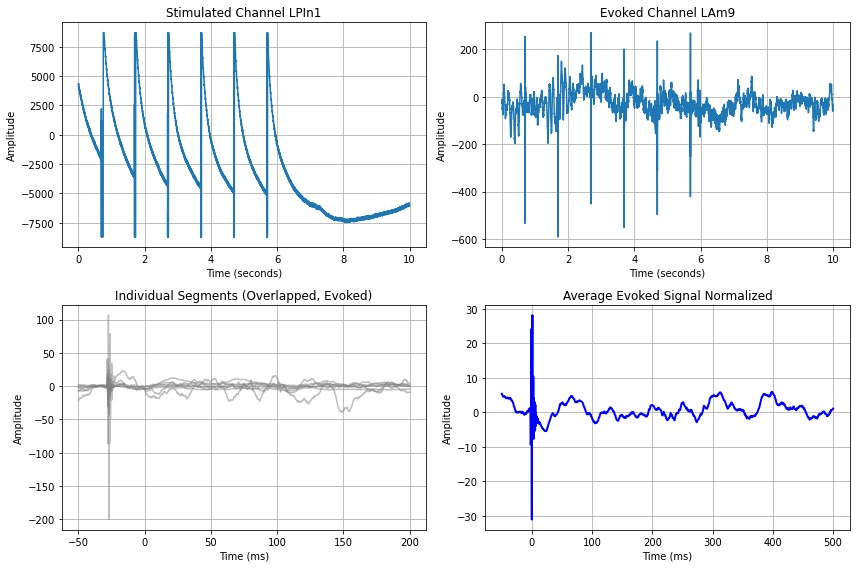

In [4]:
#CORRECT EVOKED POTENTIAL PLOTTING CODE

import numpy as np
import pyedflib
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import re

# Parameters
stimulated_channel = "LPIn1"
evoked_channel = "LAm9"
current = '3'
patient_id = "P102"

#edf_file.close()
# Open the EDF file
edf_file = pyedflib.EdfReader('/Volumes/Backup Plus/neurosurgery/ccep files/sub-P153_ses-001_task-ccep_run-01_ieeg.edf')
print("rrun")
# Get annotations (events)
annotations = edf_file.readAnnotations()

# Initialize list to store all events
all_events = []
current_pair = None

# Collect timestamps and events
for timestamp, label in zip(annotations[0], annotations[2]):
    if label.startswith('Closed relay'):
        match = re.match(r'Closed relay to (\S+) and (\S+)', label)
        if match:
            current_pair = (match.group(1), match.group(2))

    if current in label:
        all_events.append((timestamp, label, current_pair))

#print (all_events)        
# Filter for the desired current and stimulated channel
filtered_events = [
    (timestamp, label, current_pair)
    for timestamp, label, current_pair in all_events
    if current in label and current_pair[0] == stimulated_channel
]

# Ensure only the first event is selected
if len(filtered_events) > 1:
    filtered_events = [filtered_events[0]]

# Output the filtered event (timestamp, label, and stimulated channel)
for event in filtered_events:
    print(f"Timestamp: {event[0]}, Event Label: {event[1]}, Stimulated Channel: {event[2][0]}")

# Get channel labels and indices
channel_labels = edf_file.getSignalLabels()
stimulated_channel_index = channel_labels.index(stimulated_channel)
evoked_channel_index = channel_labels.index(evoked_channel)

# Extract the sampling rate
sampling_rate = edf_file.getSampleFrequency(stimulated_channel_index)

# Get the timestamp of the first filtered event
event_timestamp = filtered_events[0][0]

# Define indices for the segment around the event (10 seconds total)
start_index = int(event_timestamp * sampling_rate)
end_index = start_index + int(10 * sampling_rate)
start_index = max(0, start_index)

print(f"start index {start_index} end index {end_index}")

# Read the signals for both channels (stimulated and evoked)
stimulated_signal = edf_file.readSignal(stimulated_channel_index, start=start_index, n=end_index - start_index)
evoked_signal = edf_file.readSignal(evoked_channel_index, start=start_index, n=end_index - start_index)
#evoked_signal = mne.filter.filter_data(evoked_signal, sampling_rate, l_freq=1, h_freq=55, verbose=False)
#evoked_signal = mne.filter.notch_filter(evoked_signal, sampling_rate, freqs=60, notch_widths=2)
#evoked_signal = lfilter(notch_filter, 1.0, evoked_signal)


# Peak detection parameters
min_peak_height_stimulated = np.mean(stimulated_signal) + 2 * np.std(stimulated_signal)
min_peak_distance = int(0.9 * sampling_rate)
min_peak_height_evoked = np.mean(evoked_signal) + 2 * np.std(evoked_signal)

# Detect peaks
stimulated_peaks = find_peaks(stimulated_signal, height=min_peak_height_stimulated, distance=min_peak_distance)[0]
evoked_peaks = find_peaks(evoked_signal, height=min_peak_height_evoked, distance=min_peak_distance)[0]

# Segment extraction and baseline correction
segments = []
all_raw_segments = []  # To store non-normalized segments for overlapping plot
segment_length = int(0.25 * sampling_rate)  # 250 ms (for 200 ms window after peak)
baseline_start = -25  # ms
baseline_end = -5  # ms

for peak in evoked_peaks:
    print("rrunning")
    # Only consider peaks after 20 ms
    if peak < int(0.02 * sampling_rate):  # 20 ms offset
        continue

    # Define the segment window from -50 ms to 200 ms around the peak
    start_sample = peak + int(-0.05 * sampling_rate)  # -50 ms
    end_sample = peak + int(0.5 * sampling_rate)  # 200 ms post-peak

    # Ensure we don't go out of bounds
    if start_sample < 0:
        start_sample = 0
    if end_sample > len(evoked_signal):
        end_sample = len(evoked_signal)

    segment = evoked_signal[start_sample:end_sample]
    raw_segment = stimulated_signal[start_sample:end_sample]  # To show on the plot
    all_raw_segments.append(raw_segment)

    # Pad the segment if it's too short
    if len(segment) < segment_length:
        segment = np.pad(segment, (0, segment_length - len(segment)), 'constant')

    # Create a time vector for the segment
    segment_times = np.linspace(-50, 500, len(segment))  # Time from -50ms to 200ms
    
    # Baseline correction: Mask for baseline (-25ms to -5ms)
    baseline_mask = (segment_times >= baseline_start) & (segment_times <= baseline_end)
    baseline_values = segment[baseline_mask]
    baseline_mean = np.mean(baseline_values)
    baseline_std = np.std(baseline_values)

    # Normalize the segment
    normalized_segment = (segment - baseline_mean) / baseline_std
    #normalized_segment = moving_average(normalized_segment, window_size=5)
    
    segments.append((segment_times, normalized_segment))

# Calculate the average evoked potential
average_evoked = np.mean([segment[1] for segment in segments], axis=0) if segments else None
#average_evoked = savgol_filter(average_evoked, window_length=51, polyorder=3)

if average_evoked is not None:
    
    # Define time vector for the average evoked potential
    evoked_time_vector = np.linspace(-50, 500, len(average_evoked))  # From -50 ms to 200 ms
    
    # Veit: work on positive peaks in 20–190 ms
    search_mask = (evoked_time_vector >= 20) & (evoked_time_vector <= 190)
    y = average_evoked

    # If your convention hasn’t been enforced earlier, enforce “max positive”:
    # (Optional if you only detect positive peaks below)
    # Flip based on the detected peak’s sign, not abs-max
    pks_pos, _ = find_peaks(y[search_mask], prominence=7)
    print("pks pos ", pks_pos)

    if len(pks_pos) == 0:
        # try negative peaks by flipping once
        y = -y
        pks_pos, _ = find_peaks(y[search_mask], prominence=7)
        print ("flipped")

    if len(pks_pos) == 0:
        print("No significant peak between 20–190 ms on the averaged trace.")
        time_to_first_peak = None
        peak_value = None
    else:
        i0 = np.where(search_mask)[0][0]
        first_peak_index = i0 + pks_pos[0]
        time_to_first_peak = evoked_time_vector[first_peak_index]
        peak_value = y[first_peak_index]
        print(f"The time to the first peak is {time_to_first_peak:.2f} ms.")
        print(f"Value of peak {peak_value:.3f}")


    # Plot 1: Stimulated signal (all 10 seconds)
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    time_stimulated = np.linspace(0, 10, len(stimulated_signal))
    plt.plot(time_stimulated, stimulated_signal)
    plt.title(f"Stimulated Channel {stimulated_channel}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Plot 2: Evoked signal (all 10 seconds)
    plt.subplot(2, 2, 2)
    time_evoked = np.linspace(0, 10, len(evoked_signal))
    plt.plot(time_evoked, evoked_signal)
    plt.title(f"Evoked Channel {evoked_channel}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Plot 3: Individual segments overlapped (after normalization)
    plt.subplot(2, 2, 3)
    for segment in segments:
        segment_time = np.linspace(-50, 200, len(segment[0]))  # Time from -50ms to 200ms
        plt.plot(segment_time, segment[1], color='gray', alpha=0.5)  # Plot normalized segments
    plt.title("Individual Segments (Overlapped, Evoked)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    
    # Plot 4: Average evoked signal
    plt.subplot(2, 2, 4)
    if average_evoked is not None:
        plt.plot(evoked_time_vector, y, label='Average Evoked', color='blue', linewidth=2)
        plt.title("Average Evoked Signal Normalized")
        plt.xlabel("Time (ms)")
        plt.ylabel("Amplitude")
        plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"./ccep_figures/{patient_id}_stim_{stimulated_channel}_evoked_{evoked_channel}_{current}mA.png", 
                format='png', dpi=300)
    plt.show()

else:
    print("No segments found for evoked potential.")
    
edf_file.close()


In [ ]:
edf_file.close()